<a href="https://colab.research.google.com/github/pireylow/stock-price-prediction-LSTM-ARIMA/blob/main/Optimise_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [3]:
#set stock information
ticker = 'SPY'
startdate = '2018-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
sdata = pdr.get_data_yahoo(ticker, start=start, end=end)

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
sdata=sdata.reindex(columns=columnsTitles)

close=sdata['Close']
close.describe()

[*********************100%***********************]  1 of 1 completed


count    1259.000000
mean      344.338904
std        66.595683
min       222.949997
25%       283.980011
50%       326.859985
75%       402.525009
max       477.709991
Name: Close, dtype: float64

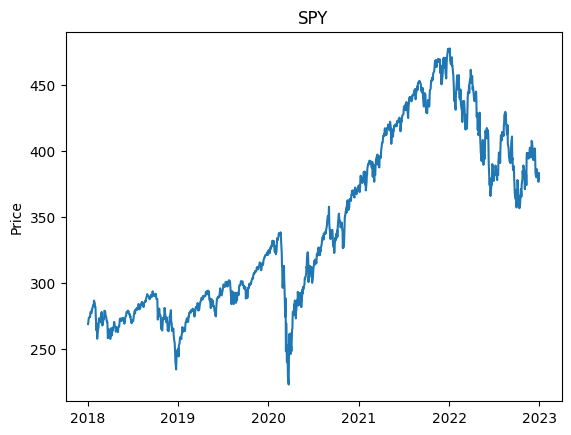

In [4]:
#simple plot for double check of data
plt.title(ticker)
plt.plot(sdata['Close'])
plt.ylabel('Price')
plt.show()

In [5]:
sdata

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,86655700,244.918625
2018-01-03,268.959991,270.640015,268.959991,270.470001,90070400,246.467804
2018-01-04,271.200012,272.160004,270.540009,271.609985,80636400,247.506592
2018-01-05,272.510010,273.559998,271.950012,273.420013,83524000,249.156052
2018-01-08,273.309998,274.100006,272.980011,273.920013,57319200,249.611633
...,...,...,...,...,...,...
2022-12-23,379.649994,383.059998,378.029999,382.910004,59857300,380.042480
2022-12-27,382.790009,383.149994,379.649994,381.399994,51638200,378.543793
2022-12-28,381.329987,383.390015,376.420013,376.660004,70911500,373.839294


In [6]:
#create price data set
Y = sdata.iloc[:,3].values
final_dataset = Y.reshape(len(Y),1) #scaler needs two dimensions

ntrvals = 1200
train_data=final_dataset[0:ntrvals,:]
valid_data=final_dataset[ntrvals:,:]


In [7]:
#scale the data set
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

"""
the above dataset with scaling is used below to run the optimization tests
"""


'\nthe above dataset with scaling is used below to run the optimization tests \n'

In [8]:
#build the LSTM training set
blocksize=60
x_train_data,y_train_data=[],[]
for i in range(blocksize,len(train_data)):
    x_train_data.append(scaled_data[i-blocksize:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
print(x_train_data.shape)
x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
print(x_train_data.shape)

(1140, 60)
(1140, 60, 1)


In [9]:
print(y_train_data[0])
print(x_train_data[0,:,0])
print(x_train_data[1,:,0])
print(x_train_data.shape[1])

0.15779556372679826
[0.17985552 0.18652852 0.19100326 0.19810809 0.20007072 0.20250437
 0.2008557  0.20870623 0.21577178 0.21204273 0.22240536 0.2205606
 0.22554564 0.23449524 0.23685042 0.23641858 0.23688959 0.24976445
 0.24230647 0.23084477 0.23139425 0.23013813 0.20607637 0.16085726
 0.18126868 0.17553783 0.13612815 0.1513189  0.1663919  0.16898259
 0.18307427 0.19657718 0.19689115 0.19017898 0.18487986 0.18625372
 0.2031716  0.21569319 0.20207253 0.1911603  0.17565558 0.18107235
 0.19327998 0.19598842 0.19559587 0.20077724 0.2195007  0.21812684
 0.21106141 0.20548749 0.20430996 0.20116979 0.18660698 0.18841269
 0.18637147 0.15983678 0.1377767  0.16548905 0.14778619 0.14476366]
[0.18652852 0.19100326 0.19810809 0.20007072 0.20250437 0.2008557
 0.20870623 0.21577178 0.21204273 0.22240536 0.2205606  0.22554564
 0.23449524 0.23685042 0.23641858 0.23688959 0.24976445 0.24230647
 0.23084477 0.23139425 0.23013813 0.20607637 0.16085726 0.18126868
 0.17553783 0.13612815 0.1513189  0.1663919

In [10]:
#build the model
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

1140/1140 - 52s - loss: 0.0032 - 52s/epoch - 46ms/step


In [12]:
#test the model
inputs_data=scaled_data[len(final_dataset)-len(valid_data)-blocksize :,:]

X_test=[]
Y_test=[]
for i in range(blocksize,inputs_data.shape[0]):
  X_test.append(inputs_data[i-blocksize:i,0])
  Y_test.append(inputs_data[i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
Y_test=np.array(Y_test)
Y_test=np.reshape(Y_test,(Y_test.shape[0],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

2/2 [==============================] - 1s 19ms/step


In [13]:
print(X_test.shape)
print(predicted_closing_price.shape)
print(len(valid_data))

mse =  (1/len(valid_data)) * np.sum((predicted_closing_price-valid_data)*(predicted_closing_price-valid_data))
print(mse)

(59, 60, 1)
(59, 1)
59
76.4961996216611


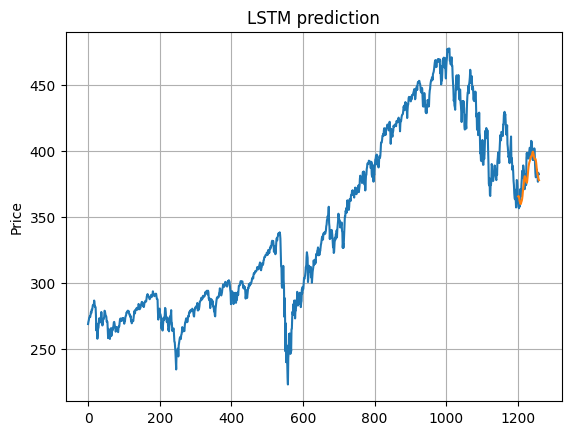

In [14]:
plt.plot(final_dataset)
plt.plot(list(range(ntrvals+1,len(close)+1)),list(predicted_closing_price))
plt.ylabel('Price')
plt.title('LSTM prediction')
plt.grid()

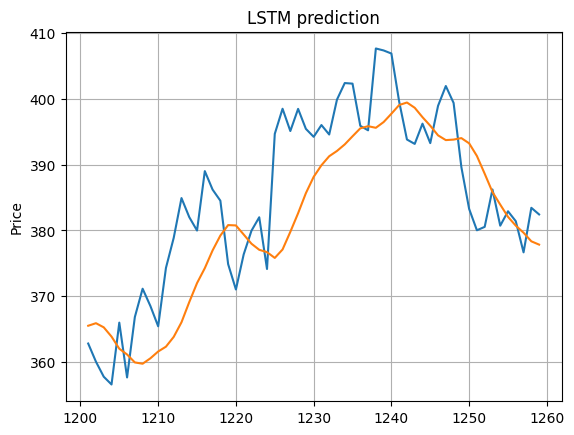

In [15]:
plt.plot(list(range(ntrvals+1,len(close)+1)),valid_data)
plt.plot(list(range(ntrvals+1,len(close)+1)),list(predicted_closing_price))

plt.ylabel('Price')
plt.title('LSTM prediction')
plt.grid()

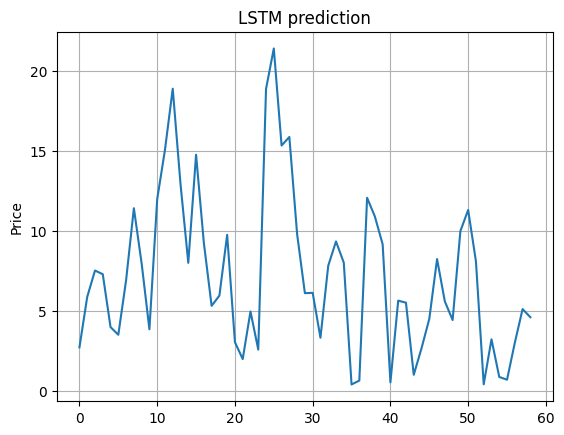

In [16]:

plt.plot(np.abs(predicted_closing_price-valid_data))
plt.ylabel('Price')
plt.title('LSTM prediction')
plt.grid()

In [17]:
#blocksize (LSTM timesteps) and n_units (LSTM units)
#blocksize_list = list(range(60,80,5))
#n_units_list = list(range(30,50,10))
blocksize_list = list(range(30,130,10))
n_units_list = list(range(30,160,10))

#set up surf matrices
blocksize_list_length=len(blocksize_list)
n_units_list_length=len(n_units_list)
X = np.zeros((blocksize_list_length,n_units_list_length))
Y = np.zeros((blocksize_list_length,n_units_list_length))
Z = np.zeros((blocksize_list_length,n_units_list_length))

blocksize_index=0
for blocksize in blocksize_list:

  n_units_index=0
  for n_units in n_units_list:

    #build the LSTM training set
    x_train_data,y_train_data=[],[]
    for i in range(blocksize,len(train_data)):
        x_train_data.append(scaled_data[i-blocksize:i,0])
        y_train_data.append(scaled_data[i,0])

    x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
    x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

    #build the model
    lstm_model=Sequential()
    lstm_model.add(LSTM(units=n_units,input_shape=(x_train_data.shape[1],1)))
    #lstm_model.add(LSTM(units=n_units,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    #lstm_model.add(LSTM(units=n_units,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
    #lstm_model.add(LSTM(units=n_units))
    #lstm_model.add(Dense(30))
    lstm_model.add(Dense(15))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss='mean_squared_error',optimizer='adam')
    lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

    #test the model
    inputs_data=scaled_data[len(final_dataset)-len(valid_data)-blocksize :,:]

    X_test=[]
    Y_test=[]
    for i in range(blocksize,inputs_data.shape[0]):
      X_test.append(inputs_data[i-blocksize:i,0])
      Y_test.append(inputs_data[i,0])
    X_test=np.array(X_test)
    X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    Y_test=np.array(Y_test)
    Y_test=np.reshape(Y_test,(Y_test.shape[0],1))
    predicted_closing_price=lstm_model.predict(X_test)
    predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

    mse =  (1/len(valid_data)) * np.sum((predicted_closing_price-valid_data)*(predicted_closing_price-valid_data))

    #update surf matrices
    X[blocksize_index,n_units_index] = blocksize
    Y[blocksize_index,n_units_index] = n_units
    Z[blocksize_index,n_units_index] = mse

    print(blocksize_index, n_units_index, blocksize, n_units)
    n_units_index+=1
  blocksize_index+=1




1170/1170 - 12s - loss: 0.0042 - 12s/epoch - 11ms/step
2/2 [==============================] - 0s 9ms/step
0 0 30 30
1170/1170 - 12s - loss: 0.0025 - 12s/epoch - 10ms/step
2/2 [==============================] - 0s 9ms/step
0 1 30 40
1170/1170 - 12s - loss: 0.0029 - 12s/epoch - 10ms/step
2/2 [==============================] - 0s 9ms/step
0 2 30 50
1170/1170 - 13s - loss: 0.0020 - 13s/epoch - 11ms/step


2/2 [==============================] - 0s 13ms/step
0 3 30 60
1170/1170 - 12s - loss: 0.0014 - 12s/epoch - 11ms/step


2/2 [==============================] - 0s 13ms/step
0 4 30 70
1170/1170 - 13s - loss: 0.0031 - 13s/epoch - 11ms/step
2/2 [==============================] - 0s 11ms/step
0 5 30 80
1170/1170 - 14s - loss: 0.0023 - 14s/epoch - 12ms/step
2/2 [==============================] - 1s 12ms/step
0 6 30 90
1170/1170 - 14s - loss: 0.0025 - 14s/epoch - 12ms/step
2/2 [==============================] - 1s 15ms/step
0 7 30 100
1170/1170 - 15s - loss: 0.0016 - 15s/epoch - 12ms/step
2/2 [==============================] - 0s 13ms/step
0 8 30 110
1170/1170 - 15s - loss: 0.0021 - 15s/epoch - 13ms/step
2/2 [==============================] - 0s 16ms/step
0 9 30 120
1170/1170 - 16s - loss: 0.0021 - 16s/epoch - 14ms/step
2/2 [==============================] - 1s 27ms/step
0 10 30 130
1170/1170 - 18s - loss: 0.0021 - 18s/epoch - 15ms/step
2/2 [==============================] - 0s 18ms/step
0 11 30 140
1170/1170 - 18s - loss: 0.0032 - 18s/epoch - 16ms/step
2/2 [==============================] - 0s 22ms/step
0 12 


LSTM timesteps with Min MSE =  90
LSTM units with Min MSE =  120
Min MSE =  47.32328016970749


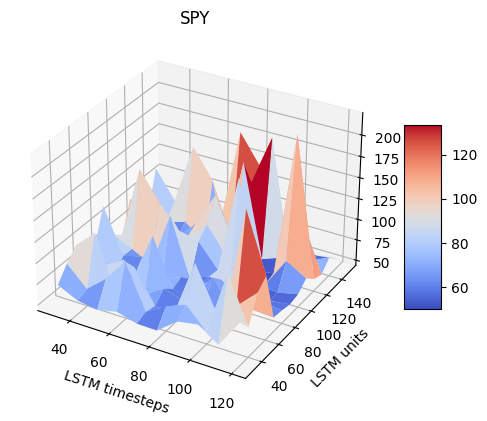

In [18]:
#get min MSE and surf plaot
print()
minptr = np.unravel_index(np.argmin(Z, axis=None), Z.shape)
print('LSTM timesteps with Min MSE = ', int(X[minptr]))
print('LSTM units with Min MSE = ', int(Y[minptr]))
print('Min MSE = ', Z[minptr])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(ticker)
ax.set_xlabel('LSTM timesteps')
ax.set_ylabel('LSTM units')
ax.set_zlabel('Prediction MSE')
plt.show()


In [19]:
Z

array([[ 71.05417134,  87.41191508,  99.97626607,  62.84773467,
         81.37397652, 120.208505  ,  76.68864815,  66.90177644,
        102.20794588,  52.9099363 ,  63.545495  , 114.45396315,
         59.78046385],
       [ 59.81456296,  64.24743928, 121.42981732,  74.86552273,
         50.62248615,  66.6989054 ,  66.08939454, 153.3383733 ,
        103.71613609,  57.32684894,  63.43531635,  80.67063708,
         59.15707432],
       [ 56.14158307,  83.686966  ,  58.7223126 ,  87.66647197,
         56.12495971,  73.05346291,  53.28317718, 119.80943335,
         57.02000149,  58.17539855,  70.44753834, 153.10588639,
         53.1504357 ],
       [ 61.4463702 , 111.43092678,  94.89991817,  52.89235771,
        113.74944008,  51.64984193, 120.34158405,  93.27575033,
         76.50227341,  83.84297545,  52.02166727, 118.95767303,
         58.91887851],
       [ 54.84630965,  59.27198081,  56.19482796,  67.68233622,
         57.31012115,  62.70804472,  50.99827135,  87.09311173,
         98.